In [1]:
import numpy as np
import matplotlib.pyplot as plt

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import cov_tools as cov

## Loading in data and Fourier transforming

Also calculating frequency covariance matrix in Fourier space

In [2]:
# loading image data:
HI_data = np.load('../Data/dT_HI_15mBeam.npy')
FG_nopol_data = np.load('../Data/dT_HI+noise+FGnopol_Stripe82_15mBeam_unsmoothednoise.npy')
FG_wpol_data = np.load('../Data/dT_HI+noise+FGwpol_Stripe82_15mBeam_unsmoothednoise.npy')

# converting to visbility:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
nx = np.shape(HI_data)[0]
ny = np.shape(HI_data)[1] # number of pixels in nx and ny direction of data (equal in our case)
ra_width = dec_width = 54.1 # width of sky in RA and Dec directions (deg)
HI_data_vis = load.generateCartDataCube(HI_data, vmin, vmax, df, nx, ny, ra_width, dec_width)
FG_nopol_data_vis = load.generateCartDataCube(FG_nopol_data, vmin, vmax, df, nx, ny, ra_width, dec_width)
FG_wpol_data_vis = load.generateCartDataCube(FG_wpol_data, vmin, vmax, df, nx, ny, ra_width, dec_width)

# calculate frequency covariance matrices:
C_HI = np.cov(HI_data_vis.data)
C_FGnopol = np.cov(FG_nopol_data_vis.data)
C_FGwpol = np.cov(FG_wpol_data_vis.data)

## HI Data

In [3]:
X = HI_data_vis.freqs/1e6
kernel_name='Exponential'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, X, 20, l=2)

Text(0.5, 1.0, 'HI data covariance')

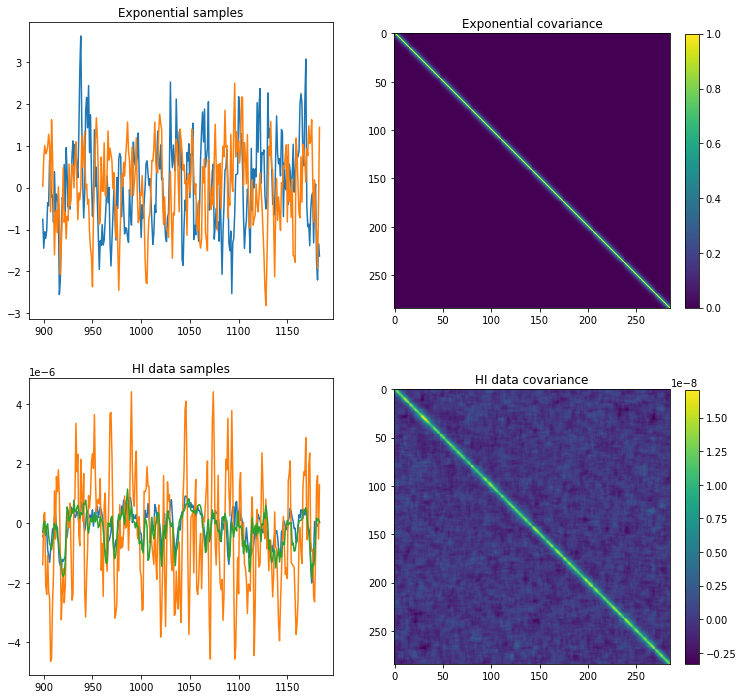

In [4]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(2):
    plt.plot(X[:],Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11,110,210):
    plt.plot(X, np.real(HI_data_vis.data[:,i]))
plt.title('HI data samples')

plt.subplot(224)
pos = plt.imshow(np.real(C_HI), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('HI data covariance')

## FG data (no polarisation)

In [5]:
X = FG_nopol_data_vis.freqs/1e6
kernel_name='Poly'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, X, 20)

In [6]:
C_FGnopol = np.cov(FG_nopol_data_vis.data[::-1])


Text(0.5, 1.0, 'FG data (no pol) covariance')

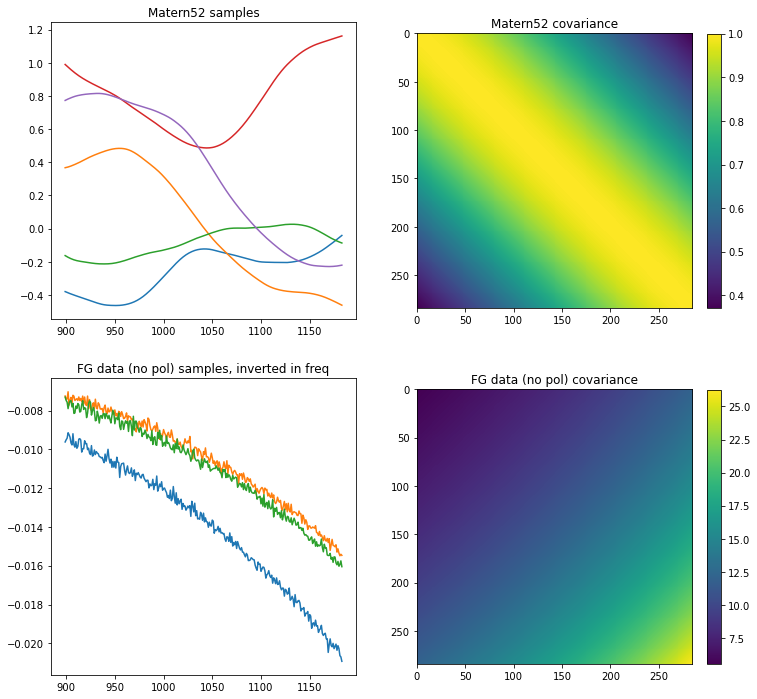

In [12]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(5):
    plt.plot(X[:],Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11,110,210):
    plt.plot(X, np.real(FG_nopol_data_vis.data[:,i][::-1]))
plt.title('FG data (no pol) samples, inverted in freq')

plt.subplot(224)
pos = plt.imshow(np.real(C_FGnopol), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('FG data (no pol) covariance')

## FG data (with polarisation)

In [13]:
X = FG_wpol_data_vis.freqs/1e6 # dividing this all by 1e6 (or another value) seems to make a difference in C
kernel_name='Matern52'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, X, 20, l=220)

In [14]:
FG_wpol_data_vis.data.shape

(285, 65536)

In [15]:
C_FGwpol.shape

(285, 285)

Text(0.5, 1.0, 'FG data (w pol) covariance')

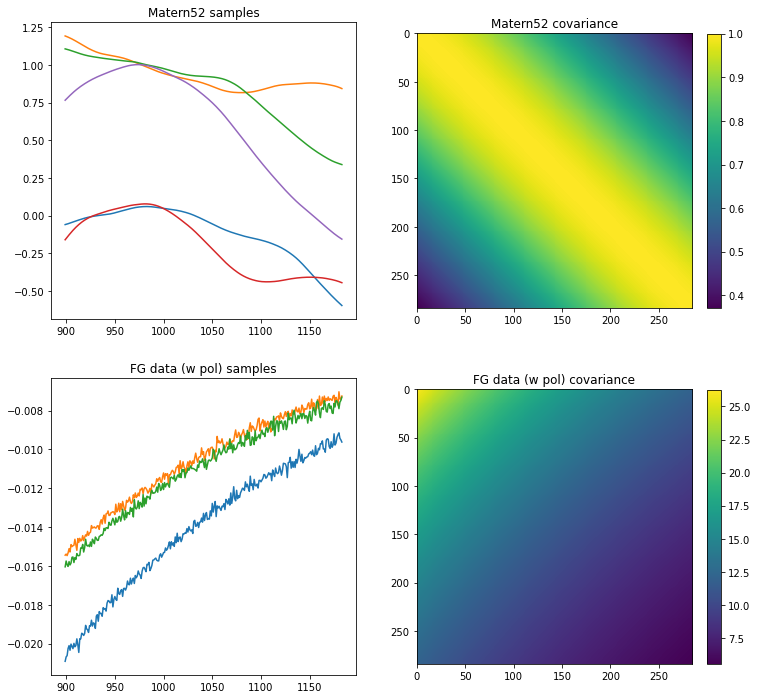

In [16]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(5):
    plt.plot(X[:],Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (11,110,210):
    plt.plot(X, np.real(FG_wpol_data_vis.data[:,i]))
plt.title('FG data (w pol) samples')

plt.subplot(224)
pos = plt.imshow(np.real(C_FGwpol), interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('FG data (w pol) covariance')

## 21cmFAST data

In [17]:
from astropy.io import fits

hdul = fits.open('../Data/obs_units_lc_faintgals_new_lownu40.36_dnu0.50.fits')
sim21cmfast_data = hdul[0].data
sim21cmfast_data = np.swapaxes(sim21cmfast_data, 1, 2)
sim21cmfast_data = np.swapaxes(sim21cmfast_data, 0, 2)

In [18]:
axes = np.shape(sim21cmfast_data)
data = np.reshape(sim21cmfast_data,(axes[0]*axes[1],axes[2]))
data = np.swapaxes(data,0,1) # [Npix, Nz] -> [Nz, Npix]
C_21cmFAST = np.cov(data)

In [19]:
X = np.linspace(40, 203, 326)
kernel_name='Exponential'
# get Z (samples from multivariate distribution with mean zero and covariance C) and C (covariance):
Z, C = cov.get_kernel_samples(kernel_name, X, 20, l=2)

Text(0.5, 1.0, '21cmFAST data covariance')

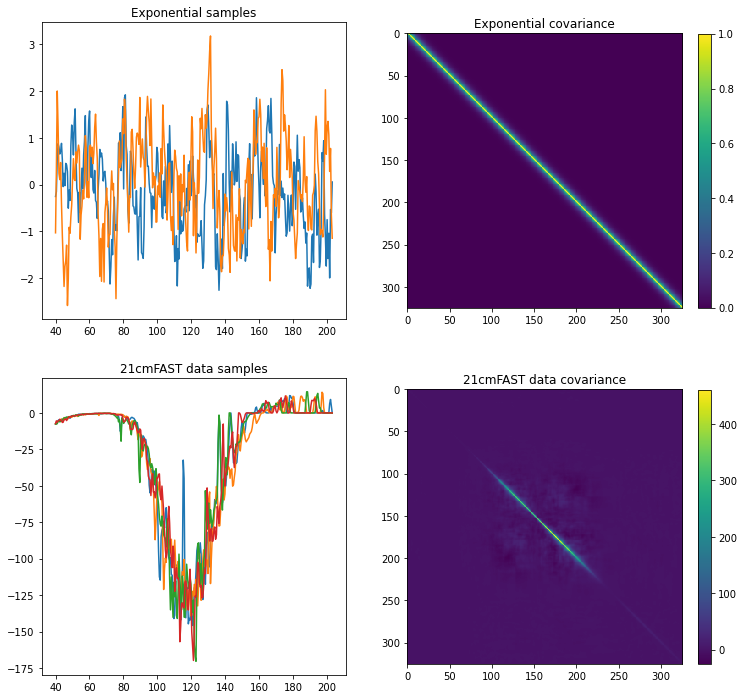

In [22]:
fig = plt.figure(figsize=(12,12))     # open a new plotting window
plt.subplot(221)
for i in range(2):
    plt.plot(X[:],Z[i,:])
plt.title('{} samples'.format(kernel_name))

plt.subplot(222)
pos = plt.imshow(C, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('{} covariance'.format(kernel_name))

plt.subplot(223)
for i in (0,100,220,300):
    plt.plot(X, np.real(data[:,i]))
plt.title('21cmFAST data samples')

plt.subplot(224)
pos = plt.imshow(C_21cmFAST, interpolation='nearest')
fig.colorbar(pos, fraction=0.045)
plt.title('21cmFAST data covariance')